In [1]:
import numpy as np
import os
import cv2
import random
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import applications, losses, optimizers, metrics, Model
from tensorflow.keras.layers import Layer, Input, Dense, Flatten, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16, vgg16
from matplotlib import gridspec
from matplotlib.image import imread
import matplotlib.pyplot as plt

In [2]:
# Check availability of GPU
import nvidia_smi 

GPU = 0
os.environ["CUDA_VISIBLE_DEVICES"] = '{}'.format(GPU)

gpus = tf.config.experimental.list_physical_devices('GPU')
print('GPU is', 'available' if gpus else 'NOT AVAILABLE')
print('Number GPUs Available: ', len(gpus))


# Restrict TensorFlow to only use the MENTIONED GPU
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print('{} Physical GPUs, Logical GPU'.format(len(gpus), len(logical_gpus)))
        print('Memory growth set to: {} '.format(str(tf.config.experimental.get_memory_growth(gpus[0]))))
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

GPU is available
Number GPUs Available:  1
1 Physical GPUs, Logical GPU
Memory growth set to: True 


2022-04-28 20:44:41.716505: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-28 20:44:42.224442: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37894 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:17:00.0, compute capability: 8.6


In [3]:
# Initiate NVIDIA-SMI
nvidia_smi.nvmlInit()
handle = nvidia_smi.nvmlDeviceGetHandleByIndex(GPU)

In [40]:
import shutil

# Separate classes into train & test; executed only once
def separate_dataset(data_src):
    directories = os.listdir(data_src)
    num_directory = len(directories)
    train_test_ratio = 0.7
    n_train = int(np.ceil(num_directory * train_test_ratio))

    train_dirs = directories[0:n_train]
    test_dirs = directories[n_train:]
    if '-1' in train_dirs: train_dirs.remove('-1')
    if '-1' in test_dirs: test_dirs.remove('-1')

    for directory in os.listdir(data_src):
        old_path = os.path.join(data_src, directory)

        if directory in train_dirs:
            train_path = os.path.join(data_src, 'train', directory)
            shutil.copytree(old_path, train_path)
        elif directory in test_dirs:
            test_path = os.path.join(data_src, 'test', directory)    
            shutil.copytree(old_path, test_path)
            
data_src = '/data/InJoon/1.5.dataset before augmentation and testing/malicious/1'
# separate_dataset(data_src)

In [4]:
class PreProcessing:

    images_train = np.array([])
    labels_train = np.array([])
    unique_train_label = np.array([])
    map_train_label_indices = dict()

    def __init__(self,data_src):
        self.data_src = data_src
        print("Loading the Dataset...")
        self.images_train, self.labels_train = self.preprocessing()
        self.unique_train_label = np.unique(self.labels_train)
        self.map_train_label_indices = {label: np.flatnonzero(self.labels_train == label) for label in
                                        self.unique_train_label}
        print('Preprocessing Done. Summary:')
        print("Images train :", self.images_train.shape)
        print("Labels train :", self.labels_train.shape)
        print("Unique label :", self.unique_train_label)

    def normalize(self,x):
        min_val = np.min(x)
        max_val = np.max(x)
        x = (x - min_val) / (max_val - min_val)
        return x

    def read_dataset(self):    
        count = 0
        for directory in os.listdir(self.data_src):
            count += len([file for file in os.listdir(os.path.join(self.data_src, directory))])

        X = [None] * count
        y = [None] * count
        idx = 0

        for directory in os.listdir(self.data_src):
            try:
                print('Read directory: ', directory)
                for pic in os.listdir(os.path.join(self.data_src, directory)):
                    img = imread(os.path.join(self.data_src, directory, pic))
                    img = tf.image.resize(img, (224,224))
                    img = self.normalize(img)

                    X[idx] = np.squeeze(np.asarray(img))
                    y[idx] = directory
                    idx += 1

            except Exception as e:
                print('Failed to read images from Directory: ', directory)
                print('Exception Message: ', e)
        print('Dataset loaded successfully.')
        return X,y

    def preprocessing(self):
        X, y = self.read_dataset()

        labels = list(set(y))
        label_dict = dict(zip(labels, range(len(labels))))
        Y = np.asarray([label_dict[label] for label in y])        

        shuffle_indices = np.random.permutation(np.arange(len(y)))
        x_shuffled = []
        y_shuffled = []
        
        for index in shuffle_indices:
            x_shuffled.append(X[index])
            y_shuffled.append(Y[index])
        
        return np.asarray(x_shuffled), np.asarray(y_shuffled)


    def get_triplets(self):
        label_l, label_r = np.random.choice(self.unique_train_label, 2, replace=False)
        a, p = np.random.choice(self.map_train_label_indices[label_l],2, replace=False)
        n = np.random.choice(self.map_train_label_indices[label_r])
        return a, p, n

    def get_triplets_batch(self):
        idxs_a, idxs_p, idxs_n = [], [], []
        n = len(self.labels_train)
        for _ in range(n):
            a, p, n = self.get_triplets()
            idxs_a.append(a)
            idxs_p.append(p)
            idxs_n.append(n)
            
        anchor_dataset = tf.data.Dataset.from_tensor_slices(self.images_train[idxs_a,:])
        positive_dataset = tf.data.Dataset.from_tensor_slices(self.images_train[idxs_p,:])
        negative_dataset = tf.data.Dataset.from_tensor_slices(self.images_train[idxs_n, :])

        dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
        
        return dataset

In [5]:
dataset = PreProcessing('/data/InJoon/1.5.dataset before augmentation and testing/malicious/1/train')

Loading the Dataset...
Read directory:  26
Read directory:  45
Read directory:  0
Read directory:  4
Read directory:  2
Read directory:  49
Read directory:  3
Read directory:  22
Read directory:  40
Read directory:  56
Read directory:  16
Read directory:  41
Read directory:  21
Read directory:  17
Read directory:  58
Read directory:  31
Read directory:  6
Read directory:  47
Read directory:  9
Read directory:  62
Read directory:  11
Read directory:  5
Read directory:  59
Read directory:  57
Dataset loaded successfully.
Preprocessing Done. Summary:
Images train : (2377, 224, 224, 3)
Labels train : (2377,)
Unique label : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [6]:
data = dataset.get_triplets_batch()

In [7]:
count = len(dataset.labels_train)

In [8]:
train_dataset = data.take(round(count * 0.8))
val_dataset = data.skip(round(count * 0.8))

In [9]:
train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [10]:
class TripletLoss:
    
    def embedding(self):
        inp = Input(shape=(224,224,3))
        
        # first block
        c1 = Conv2D(32, (7,7), activation='relu', padding='same', kernel_initializer=tf.keras.initializers.GlorotNormal())(inp)
        m1 = MaxPooling2D((2,2), padding='same')(c1)

        # second block
        c2 = Conv2D(64, (5,5), activation='relu', padding='same', kernel_initializer=tf.keras.initializers.GlorotNormal())(m1)
        m2 = MaxPooling2D((2,2), padding='same')(c2)

        # third block
        c3 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer=tf.keras.initializers.GlorotNormal())(m2)
        m3 = MaxPooling2D((2,2), padding='same')(c3)
        
        # fourth block
        c4 = Conv2D(256, (1,1), activation='relu', padding='same', kernel_initializer=tf.keras.initializers.GlorotNormal())(m3)
        m4 = MaxPooling2D((2,2), padding='same')(c4)

        c5 = Conv2D(28, (1,1), activation=None, padding='same', kernel_initializer=tf.keras.initializers.GlorotNormal())(m4)
        m5 = MaxPooling2D((2,2), padding='same')(c5)

        f1 = Flatten()(m5)
        
        return Model(inputs=[inp], outputs=[f1], name='embedding')

In [11]:
class DistanceLayer(Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [12]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):

        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # List metrics here so the `reset_states()` can be called automatically.
        return [self.loss_tracker]

In [13]:
model = TripletLoss()
target_shape = (224,224)

# Setup Network
anchor_input = Input(name="anchor", shape=target_shape + (3,))
positive_input = Input(name="positive", shape=target_shape + (3,))
negative_input = Input(name="negative", shape=target_shape + (3,))

embedding = model.embedding()
distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(positive_input),
    embedding(negative_input),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [14]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001), metrics=['accuracy'])
siamese_model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20


2022-04-28 20:48:43.989476: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


60/60 [==============================] - 12s 147ms/step - loss: 0.0282 - val_loss: 0.0151
Epoch 2/20
60/60 [==============================] - 8s 135ms/step - loss: 0.0121 - val_loss: 0.0114
Epoch 3/20
60/60 [==============================] - 8s 137ms/step - loss: 0.0066 - val_loss: 0.0109
Epoch 4/20
60/60 [==============================] - 8s 140ms/step - loss: 0.0054 - val_loss: 0.0105
Epoch 5/20
60/60 [==============================] - 8s 138ms/step - loss: 0.0079 - val_loss: 0.0109
Epoch 6/20
60/60 [==============================] - 8s 142ms/step - loss: 0.0066 - val_loss: 0.0080
Epoch 7/20
60/60 [==============================] - 8s 137ms/step - loss: 0.0036 - val_loss: 0.0080
Epoch 8/20
60/60 [==============================] - 8s 137ms/step - loss: 0.0026 - val_loss: 0.0076
Epoch 9/20
60/60 [==============================] - 9s 151ms/step - loss: 0.0013 - val_loss: 0.0072
Epoch 10/20
60/60 [==============================] - 8s 134ms/step - loss: 0.0013 - val_loss: 0.0081
Epoch 11/

In [15]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

2022-04-28 20:58:26.194985: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


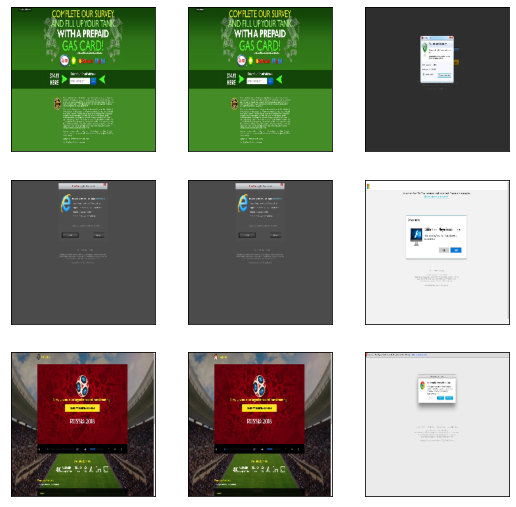

In [16]:
sample = train_dataset.as_numpy_iterator().next()
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(anchor),
    embedding(positive),
    embedding(negative),
)

In [159]:
cosine_similarity = metrics.CosineSimilarity()
positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)

print("Positive similarity:", positive_similarity.numpy())

Positive similarity: 0.9747466


In [160]:
cosine_similarity = metrics.CosineSimilarity()
negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)

print("Negative similarity", negative_similarity.numpy())

Negative similarity 0.6070819


In [161]:
cosine_similarity = metrics.CosineSimilarity()

same = cosine_similarity(anchor_embedding, anchor_embedding)
same.numpy()

1.0

## Test Dataset

In [221]:
def normalize(x):
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x - min_val) / (max_val - min_val)
    return x

def read_dataset(data_src):    
    count = 0
    for directory in os.listdir(data_src):
        count += len([file for file in os.listdir(os.path.join(data_src, directory))])

    X = [None] * count
    y = [None] * count
    idx = 0

    for directory in os.listdir(data_src):
        try:
            print('Read directory: ', directory)
            for pic in os.listdir(os.path.join(data_src, directory)):
                img = imread(os.path.join(data_src, directory, pic))
                img = tf.image.resize(img, (224,224))
                img = normalize(img)

                X[idx] = np.squeeze(np.asarray(img))
                y[idx] = directory
                idx += 1

        except Exception as e:
            print('Failed to read images from Directory: ', directory)
            print('Exception Message: ', e)
    print('Dataset loaded successfully.')
    return X,y

test_data_src = '/data/InJoon/1.5.dataset before augmentation and testing/malicious/1/test'

def preprocessing(test_data_src):
    X, y = read_dataset(test_data_src)

    labels = list(set(y))
    label_dict = dict(zip(labels, range(len(labels))))
    Y = np.asarray([label_dict[label] for label in y])        

    shuffle_indices = np.random.permutation(np.arange(len(y)))
    x_shuffled = []
    y_shuffled = []

    for index in shuffle_indices:
        x_shuffled.append(X[index])
        y_shuffled.append(Y[index])

    return np.asarray(x_shuffled), np.asarray(y_shuffled)

test_images, test_labels = preprocessing(test_data_src)

Read directory:  48
Read directory:  34
Read directory:  14
Read directory:  61
Read directory:  63
Read directory:  1
Read directory:  36
Read directory:  10
Read directory:  23
Dataset loaded successfully.


In [ ]:
11,  14,  17,  18,  26

In [223]:
unique_test_labels = np.unique(test_labels)

In [224]:
map_test_label_indices = {label: np.flatnonzero(test_labels == label) for label in unique_test_labels}

In [225]:
map_test_label_indices

{0: array([  1,   2,   3,   5,   8,   9,  10,  13,  15,  20,  21,  22,  23,
         24,  25,  28,  29,  32,  33,  36,  38,  39,  41,  43,  44,  46,
         47,  48,  52,  57,  59,  61,  62,  63,  67,  68,  69,  70,  72,
         74,  77,  78,  79,  81,  82,  87,  88,  89,  90,  91,  94,  95,
         96,  97,  98, 104, 106, 109, 110, 112, 113, 114, 115, 116, 117,
        118, 120, 121, 123, 126, 128, 133, 134, 136, 139, 140, 141, 142,
        144, 145, 146, 151, 152, 154, 155, 156, 157, 159, 160, 161, 165,
        166, 167, 169, 170, 171, 173, 177, 179, 180, 184, 187, 188, 189,
        191, 194, 195, 196, 201, 208, 209, 211, 213, 214, 217, 218, 219,
        221, 222, 224, 226, 227, 230, 235, 236, 244, 246, 247, 251, 257,
        258, 259, 260, 262, 263, 265, 266, 269, 270, 271, 275, 276, 277,
        279, 280, 282, 286, 287, 288, 290, 292, 294, 295, 296, 297, 300,
        302, 304, 306, 308, 312, 313, 314, 315, 320, 323, 325, 329, 331,
        332, 336, 337, 338, 340, 341, 343, 345, 

## Define Matrix

In [226]:
matrix = [[0 for x in range(922)] for y in range(922)]
rows, cols = len(matrix), len(matrix[0])

for r in range(rows):
    for c in range(r+1, cols):
        cosine_similarity = metrics.CosineSimilarity()
        im1 = tf.expand_dims(test_images[r], axis=0)
        im2 = tf.expand_dims(test_images[c], axis=0)
        embedding1 = embedding(im1)
        embedding2 = embedding(im2)
        
        similarity = cosine_similarity(embedding1, embedding2)

        # compute distance matrix
        matrix[r][c] = 1 - similarity.numpy()
    
    if r % 10 == 0:
        print("ROW:", r)

ROW: 0
ROW: 10
ROW: 20
ROW: 30
ROW: 40
ROW: 50
ROW: 60
ROW: 70
ROW: 80
ROW: 90
ROW: 100
ROW: 110
ROW: 120
ROW: 130
ROW: 140
ROW: 150
ROW: 160
ROW: 170
ROW: 180
ROW: 190
ROW: 200
ROW: 210
ROW: 220
ROW: 230
ROW: 240
ROW: 250
ROW: 260
ROW: 270
ROW: 280
ROW: 290
ROW: 300
ROW: 310
ROW: 320
ROW: 330
ROW: 340
ROW: 350
ROW: 360
ROW: 370
ROW: 380
ROW: 390
ROW: 400
ROW: 410
ROW: 420
ROW: 430
ROW: 440
ROW: 450
ROW: 460
ROW: 470
ROW: 480
ROW: 490
ROW: 500
ROW: 510
ROW: 520
ROW: 530
ROW: 540
ROW: 550
ROW: 560
ROW: 570
ROW: 580
ROW: 590
ROW: 600
ROW: 610
ROW: 620
ROW: 630
ROW: 640
ROW: 650
ROW: 660
ROW: 670
ROW: 680
ROW: 690
ROW: 700
ROW: 710
ROW: 720
ROW: 730
ROW: 740
ROW: 750
ROW: 760
ROW: 770
ROW: 780
ROW: 790
ROW: 800
ROW: 810
ROW: 820
ROW: 830
ROW: 840
ROW: 850
ROW: 860
ROW: 870
ROW: 880
ROW: 890
ROW: 900
ROW: 910
ROW: 920


In [227]:
# copy upper triagnle of the matrix to the lower triangle
matrix = np.triu(matrix)
matrix = matrix + matrix.T - np.diag(np.diag(matrix))

## Find the Optimal Value for Epsilon

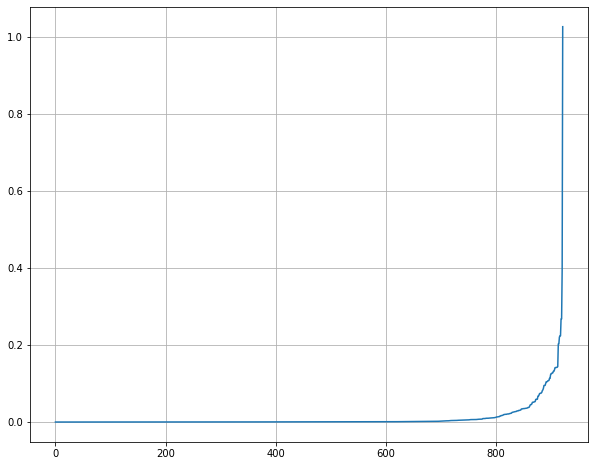

In [250]:
from sklearn.neighbors import NearestNeighbors

# locate the optimal epsilon value where the curvature is maximum in the graph
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(matrix)
distances, indices = nbrs.kneighbors(matrix)

distances = np.sort(distances, axis=0)
distances = distances[:,1]


fig = plt.figure()
ax = fig.gca()
ax.set_yticks(np.arange(0, 4., 0.2))
plt.grid()
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(distances)

## DBSCAN

In [328]:
from sklearn.cluster import DBSCAN

distance_matrix = np.array(matrix)
clustering = DBSCAN(eps=0.1, min_samples=10).fit(distance_matrix)
cluster = clustering.labels_

In [329]:
list(set(cluster))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1]

In [322]:
# sort cluster and keep track of label
sorted_cluster_labels = [i[0] for i in sorted(enumerate(cluster), key=lambda x:x[1], reverse=True)]

In [323]:
# make a copy of test images
test_dataset = test_images.copy()
test_dataset = np.array(test_dataset)

# make a copy of test labels
test_labels_copy = test_labels.copy()

In [325]:
# rearrange test images based on the sorted cluster label
test_dataset = test_dataset[sorted_cluster_labels]

# rearrange labels accordingly as well
test_labels_copy = test_labels_copy[sorted_cluster_labels]

In [327]:
test_labels_copy

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5,

In [330]:
# Rearrange rows and cols on the DBSCAN cluster labels
distance_matrix = distance_matrix[:, sorted_cluster_labels]
distance_matrix = distance_matrix[sorted_cluster_labels, :]

## Matrix: Before

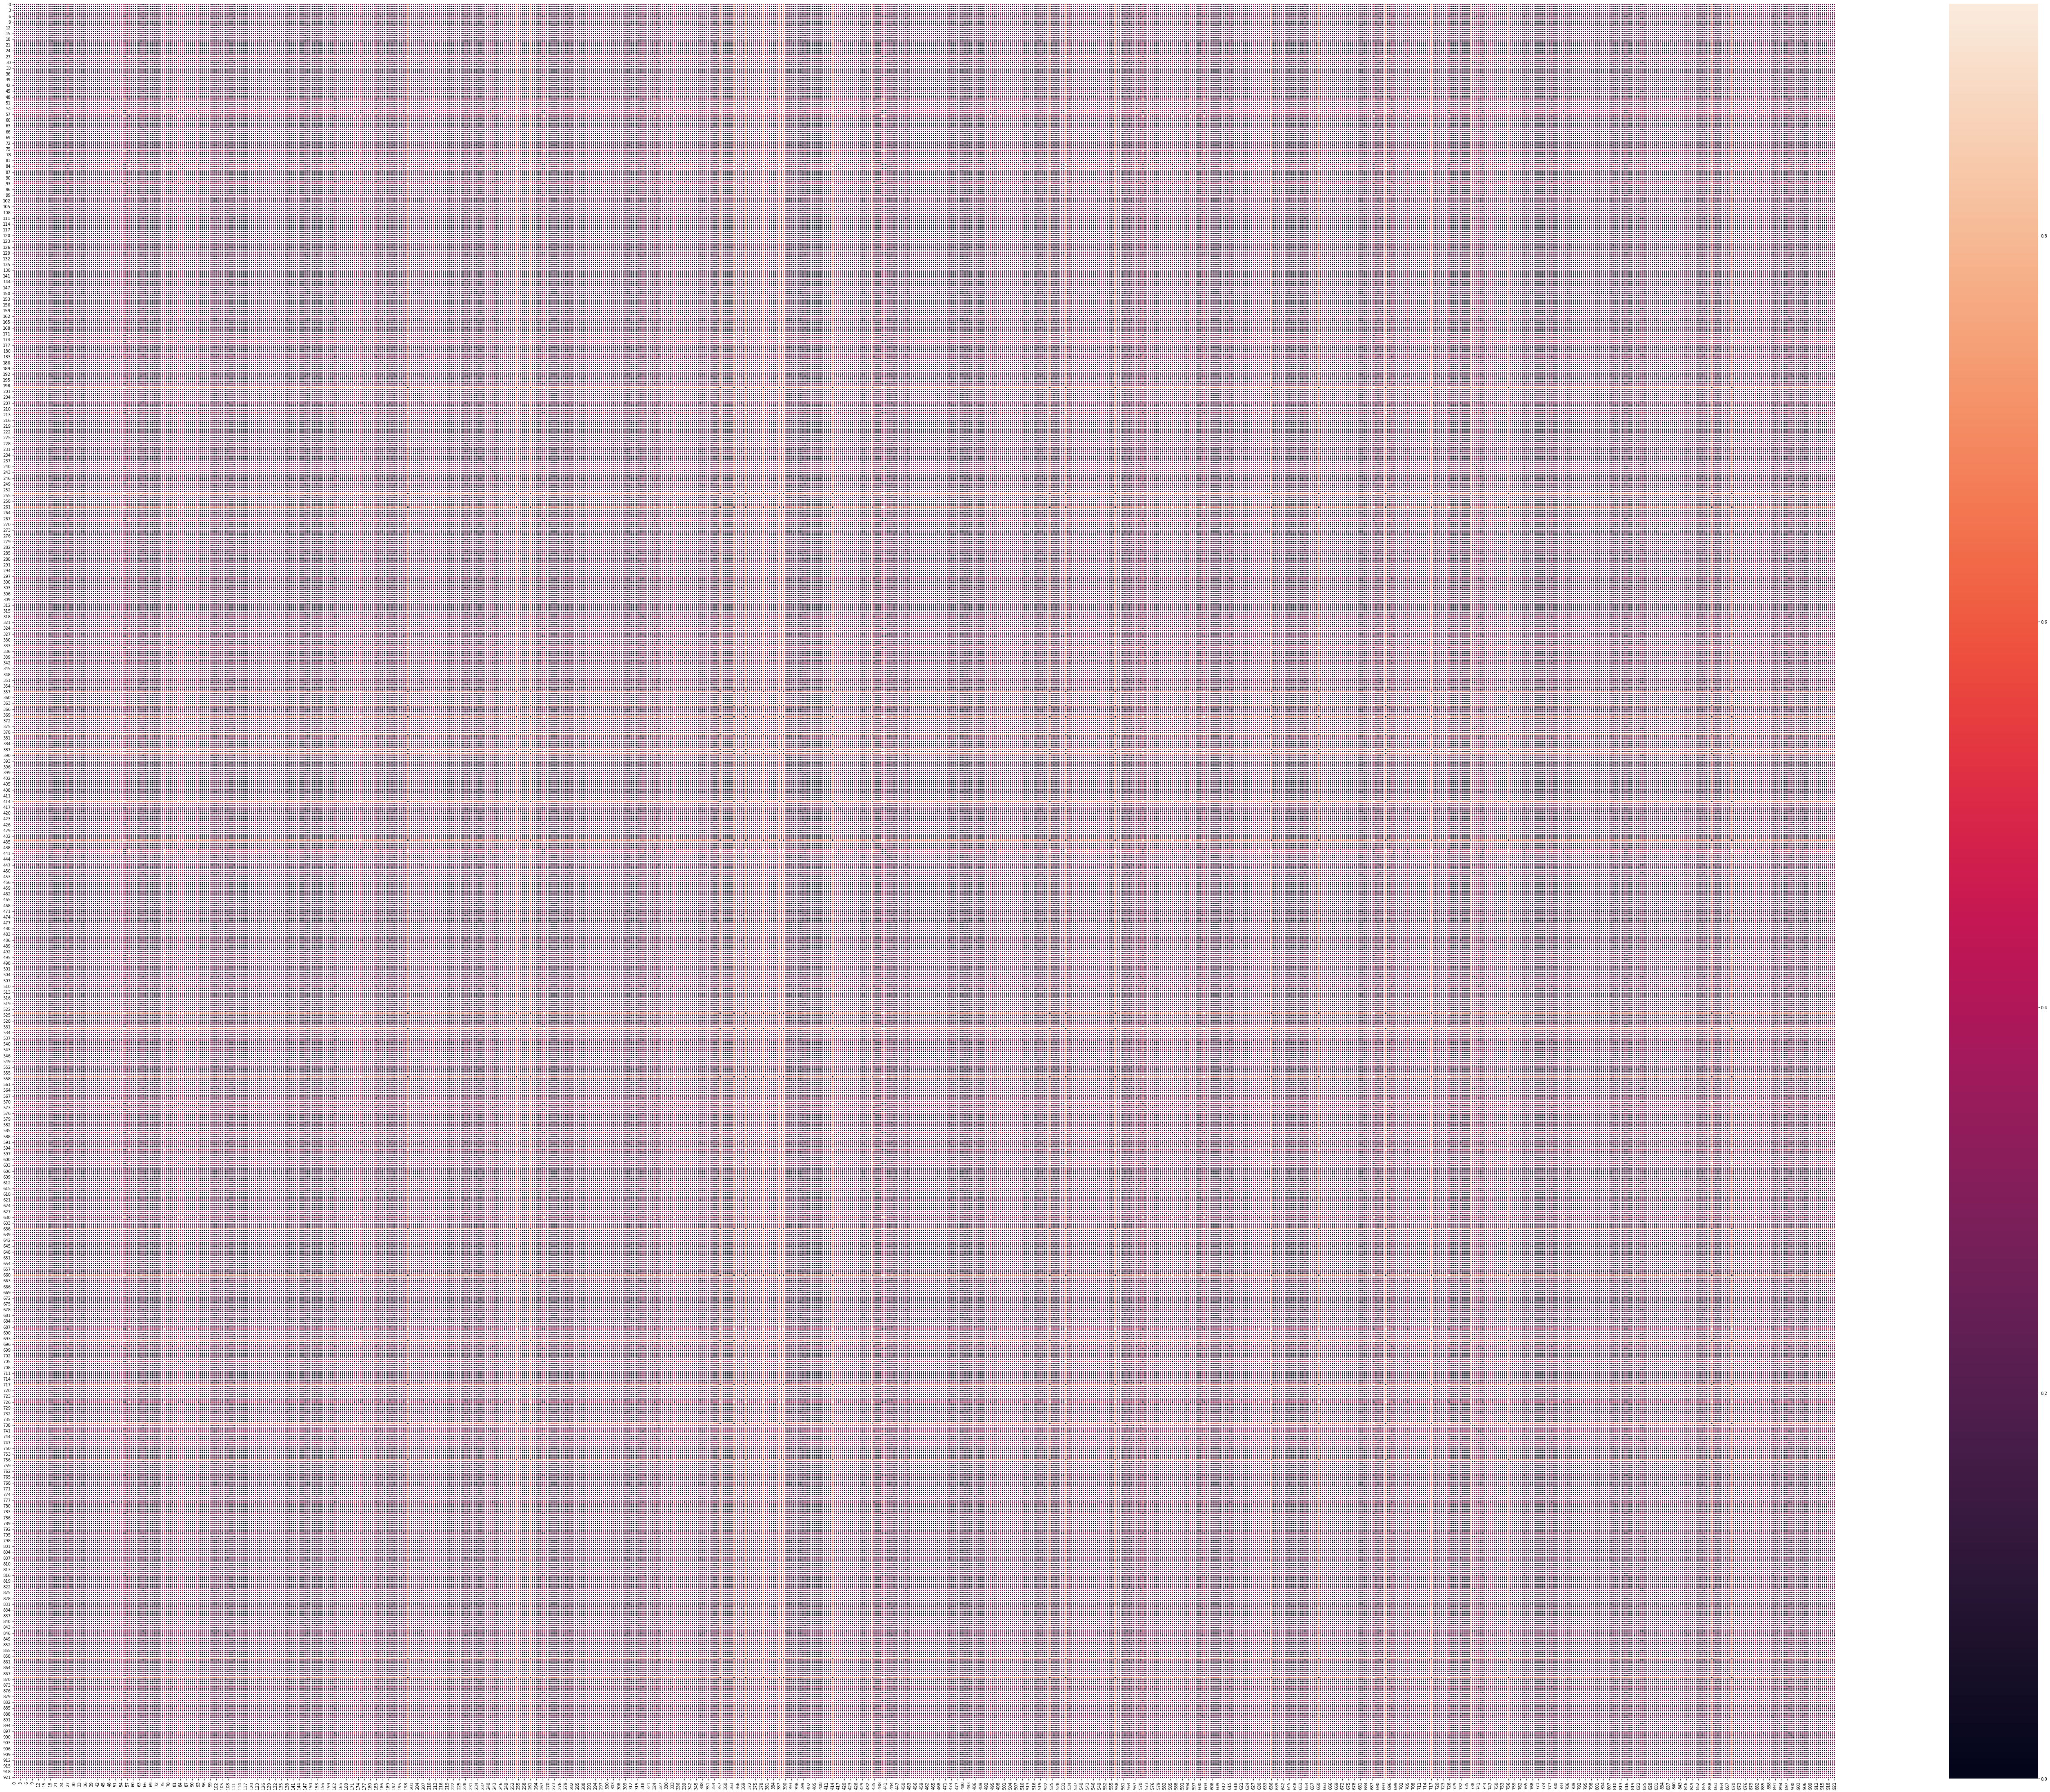

In [331]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [100, 80]
ax = sns.heatmap(matrix, linewidth=0.01)
plt.show()

## Matrix: After

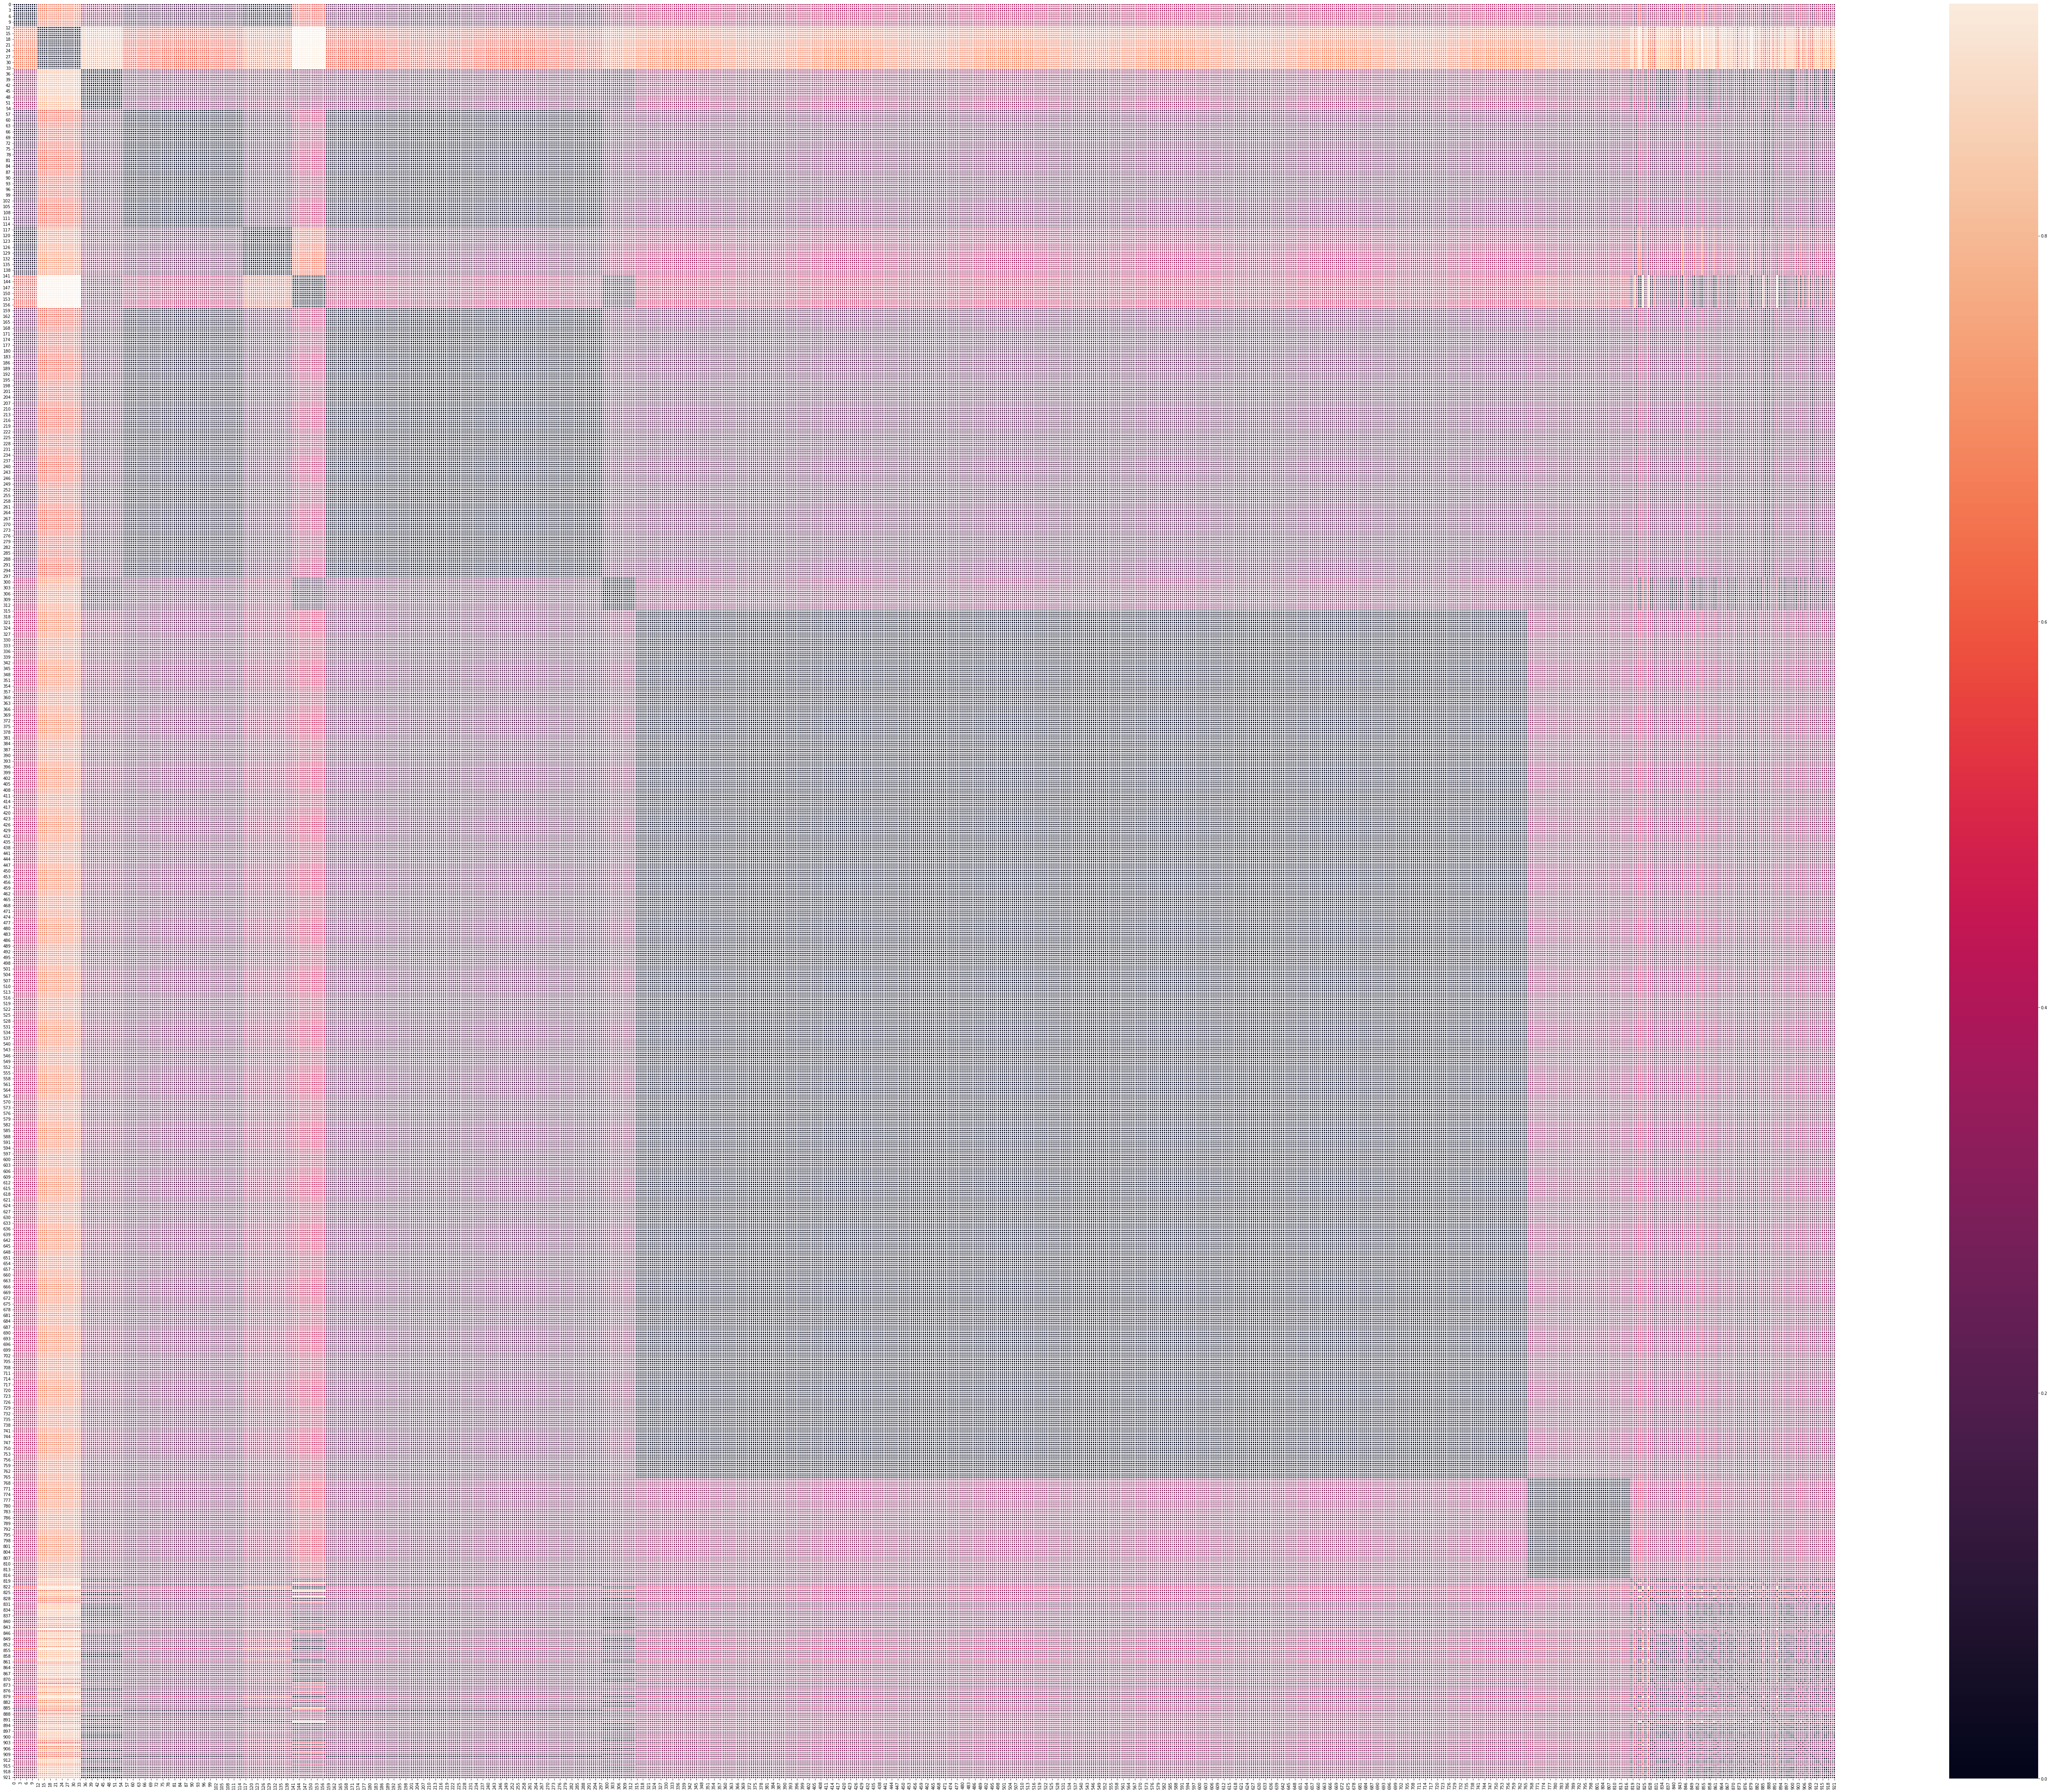

In [332]:
ax = sns.heatmap(distance_matrix, linewidth=0.01)
plt.show()

## Visualize Clusters

In [345]:
sorted_cluster = sorted(cluster, reverse=True)
cluster_unq_list = list(set(cluster))
cluster_unq_list = sorted(cluster_unq_list, reverse=True)

In [346]:
cluster_unq_list

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, -1]

In [347]:
for i in range(len(cluster_unq_list)):
    if i == len(cluster_unq_list)-1:
        next_label_idx = 922
    else:
        next_label_idx = sorted_cluster.index(cluster_unq_list[i+1])
    print(next_label_idx)

12
34
55
116
126
141
158
298
315
766
818
922


[11 10  0  2  3]
[16 24 20 25 14]
[37 41 42 35 50]
[101 103  60  75  77]
[118 120 117 125 123]
[132 133 127 138 137]
[152 154 144 151 150]
[269 220 231 206 239]
[300 302 299 310 306]
[541 435 361 744 348]
[795 800 775 796 778]
[863 876 851 891 880]


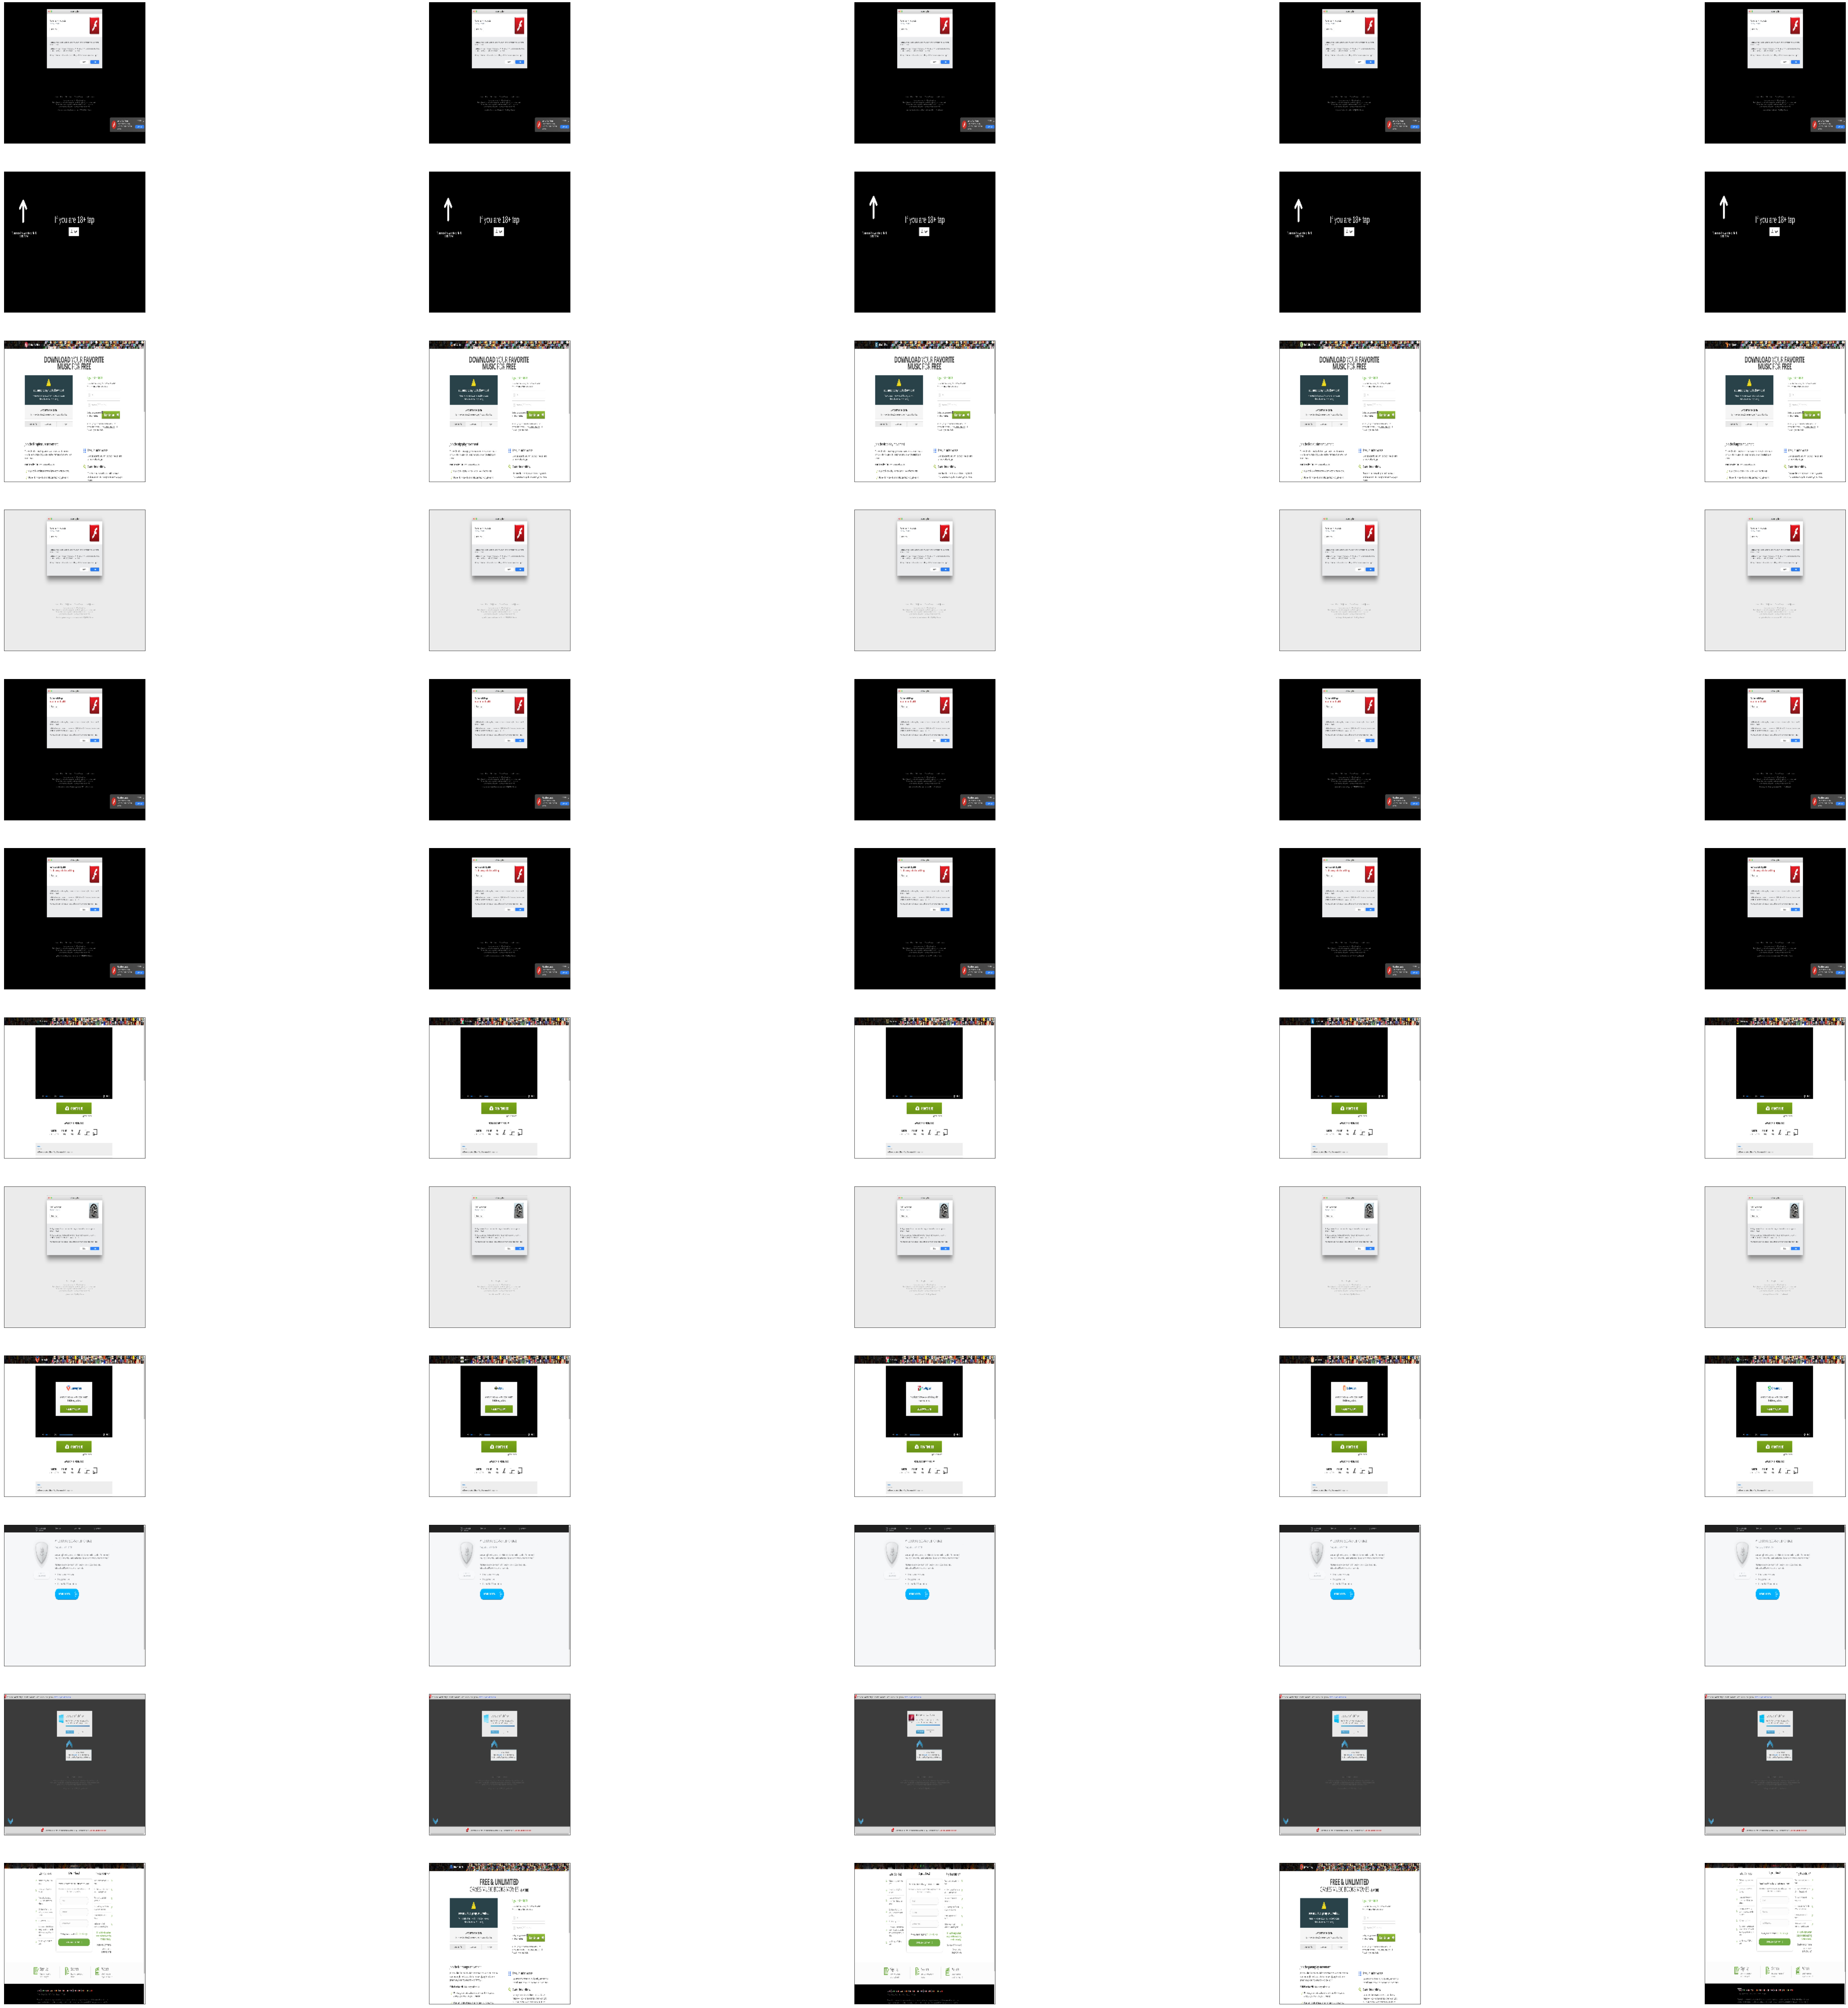

In [349]:
def show(ax, image):
    ax.imshow(image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig_len = len(cluster_unq_list) * 5
fig, axs = plt.subplots(len(cluster_unq_list),5,figsize=(100, 100))

start_idx = 0
for i in range(len(cluster_unq_list)):
    # index of the next label
    if i == len(cluster_unq_list)-1:
        next_label_idx = 922
    else:
        next_label_idx = sorted_cluster.index(cluster_unq_list[i+1])
    
    # choose 5 indices randomly that belong to the same label
    five_random_idx = np.random.choice(list(range(start_idx, next_label_idx)), 5, replace=False)
    start_idx = next_label_idx
    print(five_random_idx)

    show(axs[i,0], test_dataset[five_random_idx[0]])
    show(axs[i,1], test_dataset[five_random_idx[1]])
    show(axs[i,2], test_dataset[five_random_idx[2]])
    show(axs[i,3], test_dataset[five_random_idx[3]])
    show(axs[i,4], test_dataset[five_random_idx[4]])

## Image Pairs for Precision and Recall

In [379]:
def generate_image_pairs(test_images):
    image_pairs = []
    labels = []

    for _ in range(len(test_labels)):
        # image pairs from the same cluster
        random_label = np.random.choice(unique_test_labels)
        a, p = np.random.choice(map_test_label_indices[random_label], 2, replace=False)

#        image_pairs.append((test_images[a], test_images[p]))
        image_pairs.append((a, p))
        labels.append(1)
            
    for _ in range(len(test_labels)):
        # image pairs from different clusters
        label_l, label_r = np.random.choice(unique_test_labels, 2, replace=False)
        a = np.random.choice(map_test_label_indices[label_l])
        n = np.random.choice(map_test_label_indices[label_r])

#         image_pairs.append((test_images[a], test_images[n]))
        image_pairs.append((a, n))
        labels.append(0)
    
    return image_pairs, labels

val_image_pairs, val_labels = generate_image_pairs(test_images)

In [398]:
cluster

array([ 0,  1,  1,  1,  0,  1,  2,  0,  1,  1,  1,  3,  0,  1,  3,  1, -1,
        3,  3, -1,  1,  1,  1,  1,  1,  1,  3,  4,  1,  1,  0,  3,  1,  1,
        3,  3,  1,  2,  1,  1,  3,  1,  3,  1,  1,  0,  1,  1,  1, -1,  5,
        3,  1, -1,  6, -1, -1,  1, -1,  1,  3,  1,  1,  1, -1,  0,  3,  1,
        1,  1,  1,  3,  1,  3,  1, -1, -1,  1,  1,  1,  6,  1,  1,  4,  3,
        4,  3,  1,  1,  1,  1,  1,  6,  4,  1,  1,  1,  1,  1, -1,  0,  7,
        7,  0,  1, -1,  1,  3,  8,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,
        3,  1,  1,  6,  1,  3, -1,  1,  7,  1,  2, -1,  7,  7,  1,  1,  3,
        1, -1,  7,  1,  1,  1,  1, -1,  1,  1,  1, -1,  3,  3,  3,  1,  1,
       -1,  1,  1,  1,  1,  0,  1,  1,  1,  5,  7,  7,  1,  1,  1, -1,  1,
        1,  1,  4,  1, -1,  4,  8,  1,  3,  1,  1, -1,  0,  5,  1, -1,  7,
        1,  1,  1,  8,  1,  3, -1,  1,  1,  1, -1, -1,  9,  7,  1,  7,  3,
        3,  7,  0,  8,  1,  1, -1,  1, -1,  1,  1, -1,  3,  1,  1,  1,  3,
        1,  1, -1,  1,  3

In [401]:
predicted_labels = []

for idx1, idx2 in val_image_pairs:
    if cluster[idx1] == -1 and cluster[idx2] == -1:
        predicted_labels.append(-1)
    elif cluster[idx1] != cluster[idx2]:
        predicted_labels.append(0)
    else:
        predicted_labels.append(1)

In [402]:
from tensorflow.keras.metrics import Precision, Recall

m = Recall()
m.update_state(val_labels, predicted_labels)
m.result().numpy()

0.81670284

In [407]:
correct = 0
incorrect = 0
for i in range(len(predicted_labels)):
    if predicted_labels[i] == -1:
        break

    if predicted_labels[i] == val_labels[i]:
        correct += 1
    else:
        incorrect += 1

In [412]:
correct / (correct + incorrect)

0.8313449023861171